# Multiclass text classification using BERT
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.


In [1]:
#hide
#!pip install transformers
import pandas as pd


In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Loading data



In [2]:

PRETRAINED_LM = "GroNLP/bert-base-dutch-cased"
%mkdir PRI_DE
TB_path="/content/PRI_DE"

In [ ]:
BATCH_SIZE = 64


In [5]:
def build_data(in_file,POS):

    import csv

    max_length=0

    # Open the input file in read mode
    input_file = open(in_file+".conllu", "r")

    # Create an empty list to store the lines
    words = ""
    root= ""
    csv_line=[]



    with open(in_file+".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["text","label"])
        root_found=False
        # Loop through each line in the input file
        c=0
        for line in input_file:

          if line!="\n":
                words=words+(line.split()[1])+" "
                if line.split()[6]=="0" and not root_found:
                  root=POS[line.split()[3]]
                  root_found=True

          else:
                c+=1
                full_text=words[0:-1]
                root_found=False
                if len(words)>max_length: max_length= len(words.split(" "))
                csv_line.append(full_text)
                csv_line.append(str(root))
                writer.writerow(csv_line)


                csv_line=[]
                words = ""
                root= ""

    print('max_length',max_length,"\n","count of examples:",c)
    # Close the input file
    input_file.close()




In [6]:

POS={}
label_names=set()

for f in ["train","dev","test"]:
   temp_pos=set()
   input_file = open(f+".conllu", "r")
   for line in input_file:
    if line!="\n":
      if line.split()[6]=="0":
        label_names.add(line.split()[3])
        temp_pos.add(line.split()[3])
   print(f,len(temp_pos),"\n",temp_pos)

label_names=list(label_names)
for i in range(len(label_names)):
  POS[label_names[i]]=i



build_data("/content/train",POS)
build_data("/content/dev",POS)
build_data("/content/test",POS)


N_labels = len(label_names)
print(POS)
print(label_names)
print("N_labels: ",N_labels)

train_df=pd.read_csv("train.csv")
valid_df=pd.read_csv("dev.csv")
test_df=pd.read_csv("test.csv")


def count_pos(df,df_name):
    print("\n ---", df_name,"---\n")
    for i in range(N_labels):
        counter = len(df.loc[df['label'] == i])
        print(i,counter)

count_pos(train_df,"train")
count_pos(valid_df,"dev")
count_pos(test_df,"test")

train 13 
 {'PRON', 'X', 'ADV', 'VERB', 'PART', 'NOUN', 'PROPN', 'ADJ', 'AUX', 'CCONJ', 'DET', 'ADP', 'NUM'}
dev 10 
 {'PRON', 'X', 'VERB', 'ADV', 'NOUN', 'INTJ', 'PROPN', 'ADJ', 'AUX', 'DET'}
test 11 
 {'X', 'VERB', 'PART', 'ADV', 'NOUN', 'INTJ', 'PROPN', 'ADJ', 'AUX', 'DET', 'PUNCT'}
max_length 29 
 count of examples: 13814
max_length 27 
 count of examples: 799
max_length 29 
 count of examples: 977
{'PRON': 0, 'X': 1, 'ADV': 2, 'VERB': 3, 'PART': 4, 'NOUN': 5, 'INTJ': 6, 'PROPN': 7, 'ADJ': 8, 'AUX': 9, 'CCONJ': 10, 'DET': 11, 'ADP': 12, 'PUNCT': 13, 'NUM': 14}
['PRON', 'X', 'ADV', 'VERB', 'PART', 'NOUN', 'INTJ', 'PROPN', 'ADJ', 'AUX', 'CCONJ', 'DET', 'ADP', 'PUNCT', 'NUM']
N_labels:  15

 --- train ---

0 8
1 5
2 25
3 10563
4 6
5 1707
6 0
7 195
8 1201
9 28
10 3
11 49
12 8
13 0
14 16

 --- dev ---

0 1
1 1
2 2
3 590
4 0
5 93
6 1
7 1
8 105
9 1
10 0
11 4
12 0
13 0
14 0

 --- test ---

0 0
1 5
2 6
3 718
4 5
5 131
6 2
7 29
8 78
9 1
10 0
11 1
12 0
13 1
14 0


In [ ]:
train_df.head()

,text,label
0,"Sehr gute Beratung , schnelle Behebung der Pro...",8
1,Die Kosten sind definitiv auch in dem Rahmen .,6
2,"Nette Gespräche , klasse Ergebnis",8
3,Ich bin seit längerer Zeit zu der Behandlung v...,6
4,"Ob bei der Terminvergabe , den Behandlungsräum...",5


## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='GroNLP/bert-base-dutch-cased', vocab_size=30073, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([13814]), torch.Size([799]), torch.Size([977]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 1.1791103432575862 
13/13 val loss: 0.7708857724299798 
Epoch:  2


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.6098323716885514 
13/13 val loss: 0.7066697764855164 
Epoch:  3


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.5166561377269251 
13/13 val loss: 0.6742716706716098 
Epoch:  4


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.4661558412567333 
13/13 val loss: 0.6461088703228877 
Epoch:  5


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.4351297837026693 
13/13 val loss: 0.6156659940114388 
Epoch:  6


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.4080710478678898 
13/13 val loss: 0.5727698310063436 
Epoch:  7


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.3863739743138905 
13/13 val loss: 0.5717295832358874 
Epoch:  8


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.366460001061636 
13/13 val loss: 0.5621498697079145 
Epoch:  9


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.350990350185721 
13/13 val loss: 0.5516641793342737 
Epoch:  10


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.340718826348031 
13/13 val loss: 0.5649682180239604 
Epoch:  11


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.3271659445017576 
13/13 val loss: 0.5487219427640622 
Epoch:  12


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.313852918230825 
13/13 val loss: 0.5494128981461892 
Epoch:  13


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.3021059426030627 
13/13 val loss: 0.5525502436436139 
Epoch:  14


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.29082908788351 
13/13 val loss: 0.5593849030824808 
Epoch:  15


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2808265472175898 
13/13 val loss: 0.5408122860468351 
Epoch:  16


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2755826068179751 
13/13 val loss: 0.5423302283653846 
Epoch:  17


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2706492208979196 
13/13 val loss: 0.5532811570626038 
Epoch:  18


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.26052730892681414 
13/13 val loss: 0.5560230486668073 
Epoch:  19


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2520174015727308 
13/13 val loss: 0.5537552386522293 
Epoch:  20


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.24674544342000176 
13/13 val loss: 0.5529094430116507 
Epoch:  21


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2415260593579323 
13/13 val loss: 0.5490451604127884 
Epoch:  22


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.24087917537393946 
13/13 val loss: 0.5536536035629419 
Epoch:  23


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.2371119361681243 
13/13 val loss: 0.5655464713390057 
Epoch:  24


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22838388105716417 
13/13 val loss: 0.5616802068857046 
Epoch:  25


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22655026828525243 
13/13 val loss: 0.5682393862650945 
Epoch:  26


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22462596344175162 
13/13 val loss: 0.5717774136708333 
Epoch:  27


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22256265009787898 
13/13 val loss: 0.5751684296589631 
Epoch:  28


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22367644487638716 
13/13 val loss: 0.5688495154564197 
Epoch:  29


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.21937351446184847 
13/13 val loss: 0.5659070083728204 
Epoch:  30


Training:   0%|          | 0/216 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

216/216 train loss: 0.22123636548510855 
13/13 val loss: 0.5670300149000608 


You can see in the output that the training and validation losses steadily decreases in each epoch.

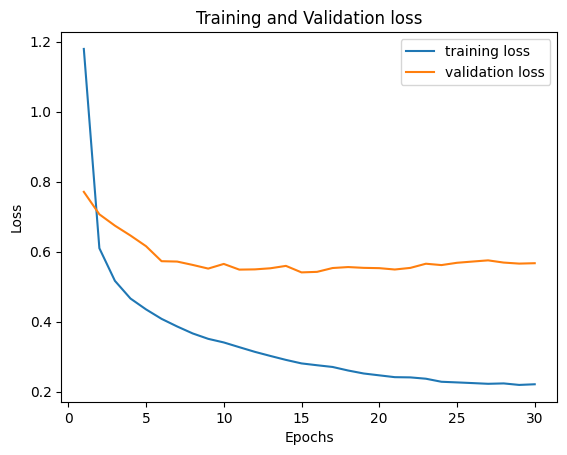

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
#print('classifiation report')
#print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [ ]:
#plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
print('classifiation report\n')
print("pos count_in_pred")

for pos in set(test_pred):
  print(label_names[pos],list(test_pred).count(pos))
print("\n\npos count_in_test")
for pos in set(test_df['label'].to_numpy()):
  print(label_names[pos],list(test_df['label'].to_numpy()).count(pos))

print("\n\n Accuracy: ",round(accuracy_score(test_pred, test_df['label'].to_numpy())*100,2))
#print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report

pos count_in_pred
NOUN 132
PROPN 21
ADJ 110
VERB 714


pos count_in_test
PART 5
AUX 1
ADV 6
ADJ 78
VERB 718
NOUN 131
DET 1
PROPN 29
X 5
INTJ 2
PUNCT 1


 Accuracy:  82.29


With the predictions, we can plot the confusion matrix again:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(173, 3)


,text,label,pred
2,Ist ja wohl ein Witz .,8,6
3,""" Bitte Termin in dem Internet machen . """,6,8
7,"Aber mal abwarten , was sich in näherer Zukunf...",6,5
10,Alle an dem Wort Gottes interessierte Personen...,6,8
14,"Also alles bestens , wie immer :)",5,8
15,"Also für eine Nacht reicht es , aber nicht noc...",6,8
16,Also wenn die Bedienung mitte 40 und blond war...,8,6
18,An dem Abend war weder der Tisch noch eine sin...,6,5
24,Auch alle anderen Speisen und der Kuchen aus e...,8,6
45,Bin 4:20 Minuten vor dem Termin .,6,8


In [ ]:
#hide

test_df.to_csv(TB_path+"/test_results.csv",index= False)
valid_df.to_csv(TB_path+"/dev_results.csv",index= False)

In [ ]:

from google.colab import files
%cd /content/





!zip -r PRI_DE.zip PRI_DE
files.download('PRI_DE.zip')


/content
  adding: PRI_DE/ (stored 0%)
  adding: PRI_DE/dev_results.csv (deflated 59%)
  adding: PRI_DE/test_results.csv (deflated 59%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>